In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.datasets import make_blobs, make_circles, fetch_lfw_people
from sklearn.svm import SVC # "Support vector classifier"
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from ipywidgets import interact, fixed
from mpl_toolkits import mplot3d
import seaborn as sns

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


/var/folders/8q/0wn9p2n54hb1x_gb6ckxsdxr0000gn/T/ipykernel_11649/434335267.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


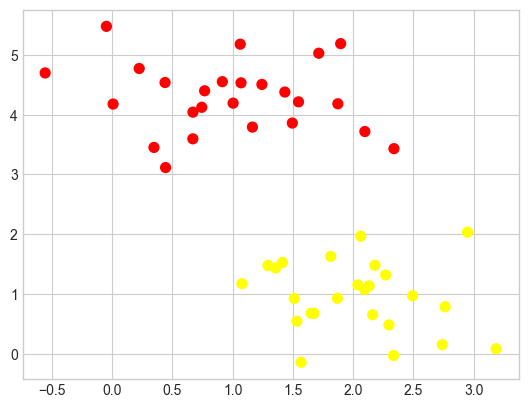

In [2]:
plt.style.use("seaborn-whitegrid")
# general classification is describing the distribution of each underlying class, and experimented with using it to determine the label associated with a given point. now we will use discriminative classification, which attempts to draw a line between the two sets of data. consider the following two-dimensional data, which has two classes:
X, y = make_blobs(n_samples=50, centers=2, random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap="autumn")

(-1.0, 3.5)

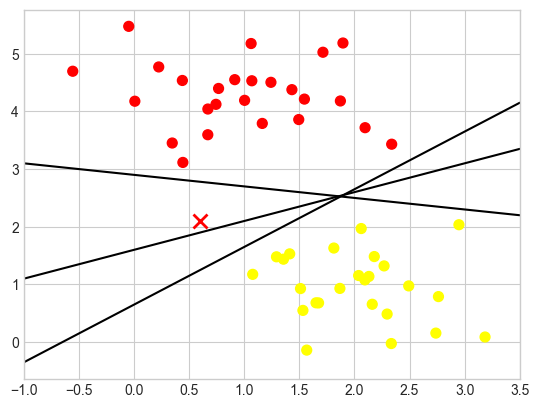

In [3]:
# a linear discriminative classifier would attempt to draw a straight line and create a model for classification there are multiple lines that can be drawn which creates a problem.
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap="autumn")
plt.plot([0.6], [2.1], "x", color="red", markeredgewidth=2, markersize=10)

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, "-k")

plt.xlim(-1, 3.5)
# these lines all work well but will classify the x differently. this is the issue with linear discriminative classifiers.

(-1.0, 3.5)

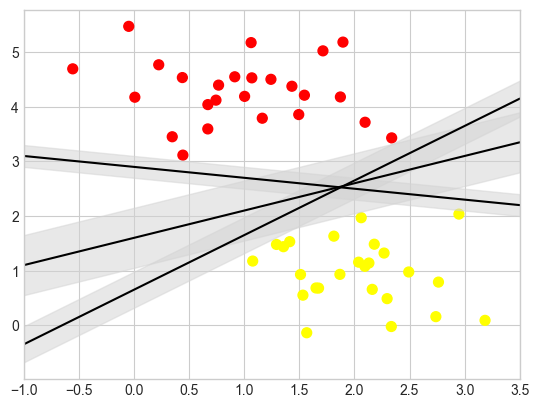

In [4]:
# maximizing the margin
# svm offer one way to improve this rather than drawing a zero-width line between the classes, we can draw around each line a margin of some width, up to the nearest point. here is an example of how this might look:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap="autumn")

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, "-k")
    plt.fill_between(
        xfit, yfit - d, yfit + d, edgecolor="none", color="lightgray", alpha=0.5
    )

plt.xlim(-1, 3.5)
# the one with the largest margin is the optimal model.

In [5]:
# lets see the result of an actual fit to this data: we will use sklearn svc to train a svm model on this data for the time being we will use a linear kernel and set the c parameter to a very large number:
model = SVC(kernel="linear", C=1e10)
model.fit(X, y)

SVC(C=10000000000.0, kernel='linear')

In [6]:
# we can create a quick convenience function that will plot svm decision boundaries for us:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)

    # plot decision boundary and margins
    ax.contour(
        X, Y, P, colors="k", levels=[-1, 0, 1], alpha=0.5, linestyles=["--", "-", "--"]
    )

    # plot support vectors
    if plot_support:
        ax.scatter(
            model.support_vectors_[:, 0],
            model.support_vectors_[:, 1],
            s=300,
            linewidth=1,
            edgecolors="black",
            facecolors="none",
        )
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

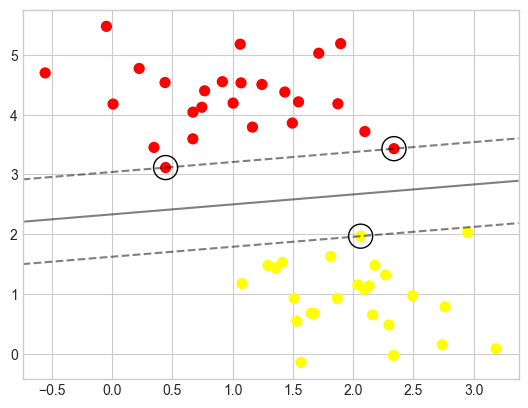

In [7]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap="autumn")
plot_svc_decision_function(model)

In [8]:
# this is the dividing line that maximizes the margin between the two sets of points. Notice that a few of the training points just touch the margin. they are circled the points are the pivotal elements of this fit. in sklearn they are stored in the support_vectors_ attribute of the classifier:
model.support_vectors_

array([[2.06156753, 1.96918596],
       [0.44359863, 3.11530945],
       [2.33812285, 3.43116792]])

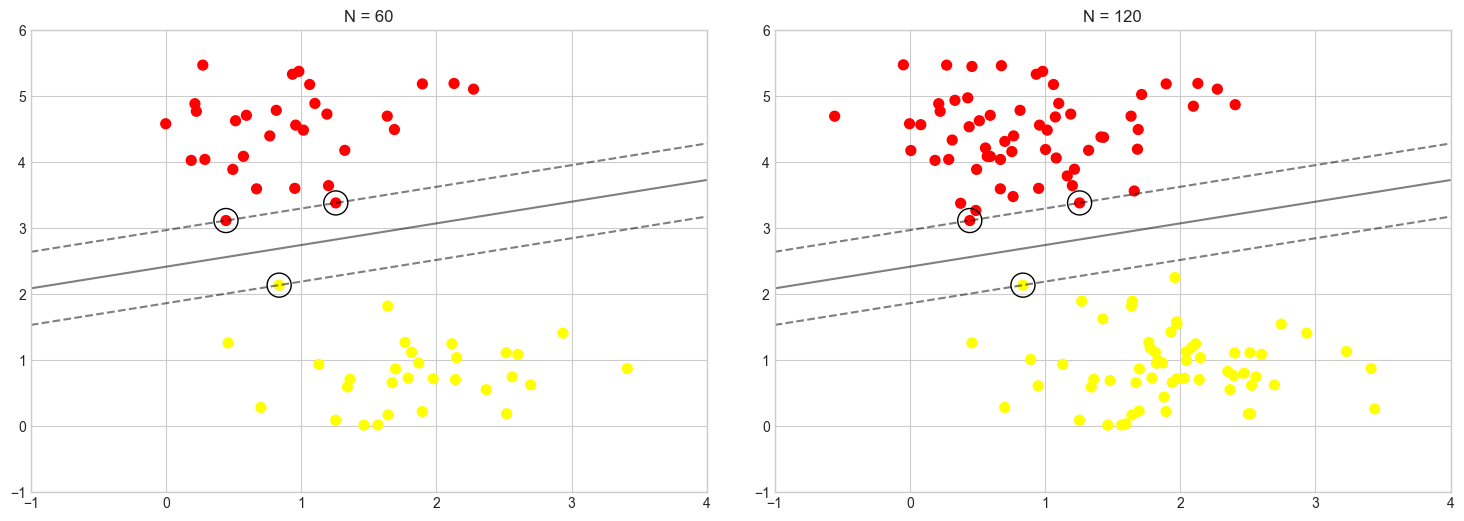

In [9]:
# a key to this classifiers sucess is that for the fit, only the positions of the support vectors matter any points further from the margin that are on the correct side and do not mofify the fit since they do not contribute to the loss function used in the fit. we can see this if we plot the model learned from the first 60 points and first 120 points of this dataset:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2, random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel="linear", C=1e10)
    model.fit(X, y)

    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap="autumn")
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)


fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi)
    axi.set_title("N = {0}".format(N))

# in the left panel, we see the model and the support vectors for 60 training plots in the right panel we have doubled the number of training plots but the model has not changed: the three support vectors from the left panel are still the support vectors from the right panel. this insensitivity to the exact behavior of distant points is one of the strengths of the svm model.

In [10]:
interact(plot_svm, N=(10, 200), ax=fixed(None))

interactive(children=(IntSlider(value=10, description='N', max=200, min=10), Output()), _dom_classes=('widget-…

<function __main__.plot_svm(N=10, ax=None)>

beyond Linear boundaries kernel svm

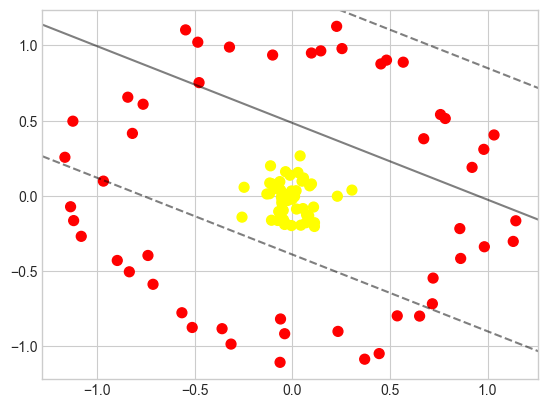

In [11]:
# where svm can be quite powerful is when it is combined with kernels. we have seen a verion of kernels before, in the basis function regressions of in depth linear regression. there we projected our data into higher dimensional space defined by polynomials and gaussian basis functions and thereby were able to fit for nonlinear relationships with a linear regressor. in svm we can use a version of the same idea. to motivate the need for kernels lets look at some data that is not linearly separable:
X, y = make_circles(100, factor=0.1, noise=0.1)

clf = SVC(kernel="linear").fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap="autumn")
plot_svc_decision_function(clf, plot_support=False)

Text(0.5, 0, 'r')

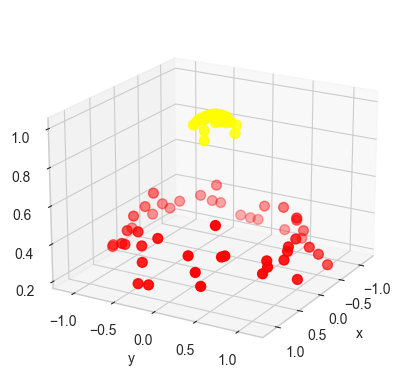

In [12]:
# its clearn that no linear discrimination will ever be able to seperate this data but we can draw a lesson from the basis function regressions in in depth linear regression and think about how we might project the data into a higher dimension such that a linear separator would be sufficient. for example one simple projection we could use would be to compute a radial basis function centered on the middle clump:
r = np.exp(-(X**2).sum(1))
# we can visualize this extra data dimension using a three dimensional plot

ax = plt.subplot(projection="3d")
ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap="autumn")
ax.view_init(elev=20, azim=30)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("r")
# we can see that with this additional dimension the data becomes trivially linearly seperable by drawing a separating plane at for example r=0.7
# in this case we had to choose and carefully tune our projection: if we had not centered our radial basis function in the right location we would not have seen such clean seperation. in general the need to make such a choice is a problem: we would like to somehow automatically find the best basis functions to use. one strategy to this end is to compute a basis function centered at every point in the dataset and let the svm algorithm sift through the results. this type of basis function transformation is known as a kernel transformation as it is based on a similarity relationship (or kernel) between each pair of points.
# a potential problem with this strategy projecting n points into n dimensions is that it might become very computationally intensive as n grows large. however because of a neat little procedure known as the kernel trick a fit on kernel transformed data can be done implicitly that is without ever building the full n dimensional representation of the kernel projection! this kernel trick is built into the svm and is one of the reasons the method is so powerful.

In [13]:
# in sklearn we can apply kernelized svm simply by changing our linear kernel to a radial basis function rbf kernel, using the kernel model hyperparameter
clf = SVC(kernel="rbf", C=1e6)
clf.fit(X, y)

SVC(C=1000000.0)

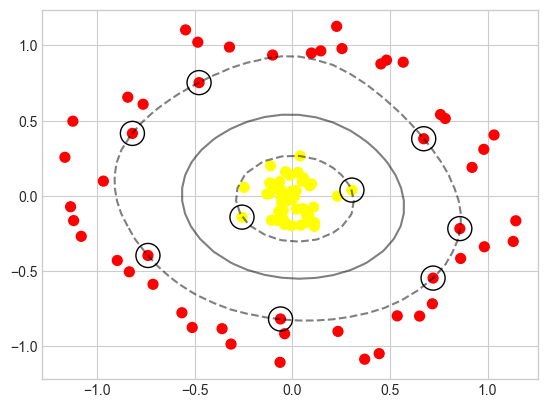

In [14]:
# we can use or precviously defined function to visualize the fit and identify the support vectors
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap="autumn")
plot_svc_decision_function(clf)
plt.scatter(
    clf.support_vectors_[:, 0],
    clf.support_vectors_[:, 1],
    s=300,
    lw=1,
    facecolors="none",
)
# by using the kernelized SVM we learn a suitable nonlinear decision boundary. this kernel transformation strategy is used often in machine learning to turn fast linear methods into fast nonlinear methods especially for models in which the kernel trick can be used.

tuning the SVM: Softening margins

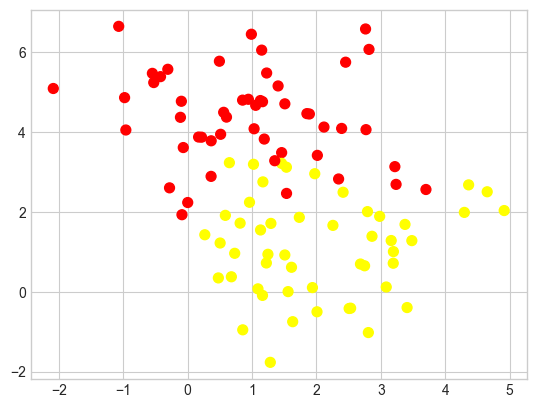

In [15]:
# our discussion thus far has centered around very clean datasets in which a perfect decison boundary exists but what if the data has some amount of overlap?
X, y = make_blobs(n_samples=100, centers=2, random_state=0, cluster_std=1.2)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap="autumn")
# to handle this case the svm implementation has a bit of a fudge factor that softens the margin that is allows some of the points to creep into the margin if that allows for a better fit. the hardness of the margin is controlled by tuning C. for a very large C the margin is hard and points cannot lie in it. for a smaller C the margin is softer and can grow to encompass some points. the plot shown in the following figure give a visual picture of how a changing C parameter affects the final fit via the softening of the margin:

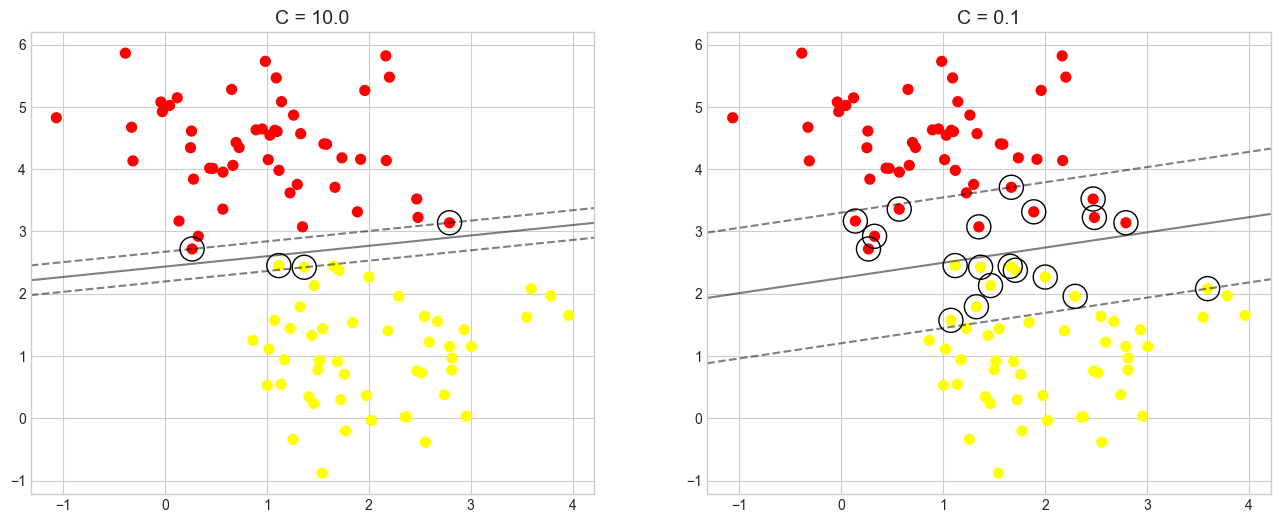

In [16]:
X, y = make_blobs(n_samples=100, centers=2, random_state=0, cluster_std=0.8)
fix, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10.0, 0.1]):
    model = SVC(kernel="linear", C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap="autumn")
    plot_svc_decision_function(model, axi)
    axi.scatter(
        model.support_vectors_[:, 0],
        model.support_vectors_[:, 1],
        s=300,
        lw=1,
        facecolors="none",
    )
    axi.set_title("C = {0:.1f}".format(C), size=14)
# the optimal value of C will depend on the dataset and should be tuned via cross validation or a similar procedure

Face Recognition

In [17]:
# As an example of SVM in action we can take a look at facial recognition. we will use the labeled faces in the wild dataset which consists of several thousand collated photos of various public figures. a fetcher for the dataset is built into scikit learn:
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Junichiro Koizumi' 'Tony Blair']
(1277, 62, 47)


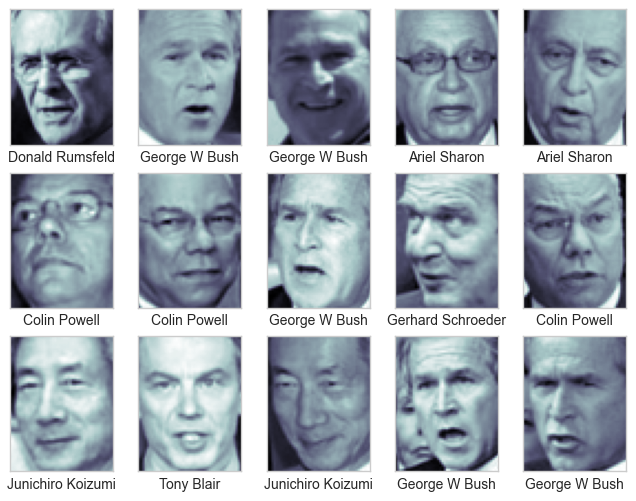

In [18]:
# we can plot a few to see what we are working with
fig, ax = plt.subplots(3, 5, figsize=(8, 6))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap="bone")
    axi.set(xticks=[], yticks=[], xlabel=faces.target_names[faces.target[i]])
# each image contains [62, 47] or nearly 3000 pixels. we could proceed by simply using each pixel value as a feature but often it is more effective to use some sort of preprocessor to extract more meaningful features. here we will use a principal component analysis to extract 150 fundamental components to feed into our support vector machine classifier. we can do this most straightforwardly by packaging the preprocessor and the classifier into a single pipeline:

In [19]:
pca = PCA(n_components=150, whiten=True, random_state=42)
svc = SVC(kernel="rbf", class_weight="balanced")
model = make_pipeline(pca, svc)

In [20]:
# for the sake of testing our classifier output we will split the data into a training and testing set:
Xtrain, Xtest, ytrain, ytest = train_test_split(
    faces.data, faces.target, random_state=42
)
# finally we can use grid search cross validation to explore combinations of parameters here will will adjust C (which controls the margin hardness) and gamma (which controls the size of the radial basis function kernel) to determine the best model:

In [21]:
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005, 0.002, 0.003, 0.004]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

CPU times: user 1min 9s, sys: 3.45 s, total: 1min 13s
Wall time: 17.5 s
{'svc__C': 10, 'svc__gamma': 0.003}


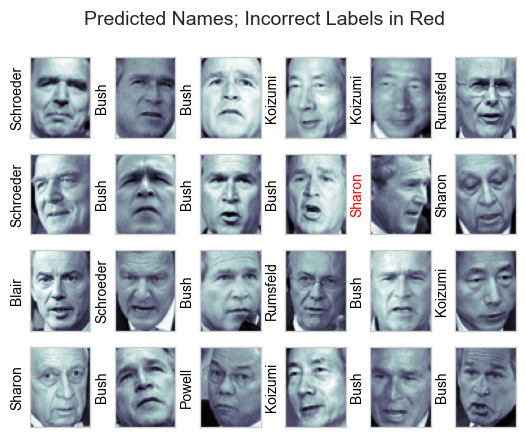

In [22]:
# the optimal values fall toward the middle of our grid if they fall at the edges we would want to expand the grid to make sure we have found the true optimum. now with this cross validated model we can predict the labels for the test data which the model has not yet seen:
model = grid.best_estimator_
yfit = model.predict(Xtest)
# we can look at a few of the test images along with their predicted values:
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap="bone")
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(
        faces.target_names[yfit[i]].split()[-1],
        color="black" if yfit[i] == ytest[i] else "red",
    )

fig.suptitle("Predicted Names; Incorrect Labels in Red", size=14)

In [23]:
# we can get a better sense of our estimator's performance using a classification report which lists recovery statistics label by label:
print(classification_report(ytest, yfit, target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.50      0.54      0.52        13
     Colin Powell       0.77      0.83      0.80        66
  Donald Rumsfeld       0.83      0.67      0.74        30
    George W Bush       0.88      0.93      0.90       139
Gerhard Schroeder       0.90      0.75      0.82        24
Junichiro Koizumi       1.00      0.94      0.97        17
       Tony Blair       0.89      0.81      0.85        31

         accuracy                           0.84       320
        macro avg       0.83      0.78      0.80       320
     weighted avg       0.85      0.84      0.84       320



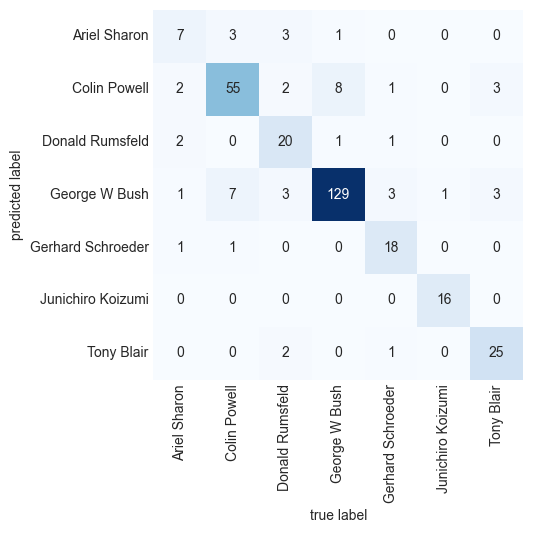

In [24]:
# we might also display the confusion matrix between these classes:
mat = confusion_matrix(ytest, yfit)
sns.heatmap(
    mat.T,
    square=True,
    annot=True,
    fmt="d",
    cbar=False,
    cmap="Blues",
    xticklabels=faces.target_names,
    yticklabels=faces.target_names,
)
plt.xlabel("true label")
plt.ylabel("predicted label")

In [ ]:
# svms are a powerful tool for classification for a number of reasons:
# Their dependence on relatively few support vectors means that they are compact and take up very little memory.
# Once the model is trained, the prediction phase is very fast.
# Because they are affected only by points near the margin, they work well with high-dimensional data—even data with more dimensions than samples, which is challenging for other algorithms.
# Their integration with kernel methods makes them very versatile, able to adapt to many types of data.
# they have some disadvantages as well:
# The scaling with the number of samples  is  at worst, or  for efficient implementations. For large numbers of training samples, this computational cost can be prohibitive.
# The results are strongly dependent on a suitable choice for the softening parameter C. This must be carefully chosen via cross-validation, which can be expensive as datasets grow in size.
# The results do not have a direct probabilistic interpretation. This can be estimated via an internal cross-validation (see the probability parameter of SVC), but this extra estimation is costly.